# Import Libraries

In [29]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import copy

import cPickle

import os
from scipy.io import loadmat

In [2]:
#plt.show() in jupyter notebook
%matplotlib inline

# Part 1

#### Analysis Data

the 1-th most prevealing word in fake news is trump :1328
the 2-th most prevealing word in fake news is the :439
the 3-th most prevealing word in fake news is to :409
the 4-th most prevealing word in fake news is in :231
the 5-th most prevealing word in fake news is donald :228
the 6-th most prevealing word in fake news is of :212
the 7-th most prevealing word in fake news is for :205
the 8-th most prevealing word in fake news is a :192
the 9-th most prevealing word in fake news is and :180
the 10-th most prevealing word in fake news is on :166


the 1-th most prevealing word in real news is trump :1744
the 2-th most prevealing word in real news is donald :829
the 3-th most prevealing word in real news is to :413
the 4-th most prevealing word in real news is us :230
the 5-th most prevealing word in real news is trumps :219
the 6-th most prevealing word in real news is in :214
the 7-th most prevealing word in real news is on :205
the 8-th most prevealing word in real news is of :186
the

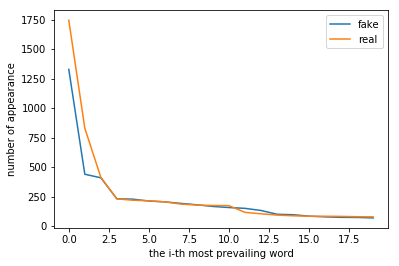

In [30]:
#import fakeData and realData from text files
fakeData = [line.rstrip('\n').split(' ') for line in open('clean_fake.txt')]
realData = [line.rstrip('\n').split(' ') for line in open('clean_real.txt')]

#count words in realData and fakeData
fakeWordsCounts = {}
realWordsCounts = {}

for i in fakeData:
    for j in i:
        if j not in fakeWordsCounts:
            fakeWordsCounts[j] = 1
        else:
            fakeWordsCounts[j] += 1

for i in realData:
    for j in i:
        if j not in realWordsCounts:
            realWordsCounts[j] = 1
        else:
            realWordsCounts[j] += 1
            
#sort words according to how often they appear
fakeWordsInOrder = sorted(fakeWordsCounts, key = fakeWordsCounts.__getitem__, reverse=True)
realWordsInOrder = sorted(realWordsCounts, key = realWordsCounts.__getitem__, reverse=True)

#plot
fig = plt.figure(11)
plt.plot(range(20), [fakeWordsCounts[fakeWordsInOrder[i]] for i in range(20)], label = "fake")
plt.plot(range(20), [realWordsCounts[realWordsInOrder[i]] for i in range(20)], label = "real")
plt.ylabel("number of appearance")
plt.xlabel("the i-th most prevailing word")
plt.legend(loc = "best")

#print the most prevailing words:
for i in range(10):
    print "the %i-th most prevealing word in fake news is %s :%i"%(i+1,fakeWordsInOrder[i],fakeWordsCounts[fakeWordsInOrder[i]])
print('\n')
for i in range(10):
    print "the %i-th most prevealing word in real news is %s :%i"%(i+1,realWordsInOrder[i],realWordsCounts[realWordsInOrder[i]])

#### Spliting data


In [52]:
random.seed(0)
fakeDataCopy = copy.deepcopy(fakeData)
realDataCopy = copy.deepcopy(realData)
random.shuffle(fakeDataCopy)
random.shuffle(realDataCopy)

fakeTrain = fakeDataCopy[:int(len(fakeDataCopy)*0.7)]
fakeVali = fakeDataCopy[int(len(fakeDataCopy)*0.7):int(len(fakeDataCopy)*0.85)]
fakeTest = fakeDataCopy[int(len(fakeDataCopy)*0.85):]

realTrain = realDataCopy[:int(len(realDataCopy)*0.7)]
realVali = realDataCopy[int(len(realDataCopy)*0.7):int(len(realDataCopy)*0.85)]
realTest = realDataCopy[int(len(realDataCopy)*0.85):]

# Part 2

In [71]:
#construct wordList that contains all the words appeared
temp = copy.copy(fakeWordsInOrder)
temp.extend(realWordsInOrder)
wordList = sorted(set(temp), key=temp.index)




['trump', 'the', 'to', 'in', 'donald', 'of', 'for', 'a', 'and', 'on', 'is', 'hillary', 'clinton', 'with', 'will', 'by', 'he', 'election', 'just', 'as', 'new', 'president', 'you', 'it', 'obama', 'his', 'if', 'at', 'america', 'are', 'be', 'that', 'win', 'from', 'victory', 'has', 'says', 'what', 'about', 'supporters', 'campaign', 'news', 'not', 'vote', 'us', 'after', 'world', 'why', 'i', 'anti', 'out', 'white', 'media', 'fbi', 'black', 'this', 'watch', 'who', 'supporter', 'voter', 'they', 'we', 'comment', 'over', 'against', 'star', 'how', 'voting', 'war', 'russia', 'putin', 'breaking', 'all', 'up', 'rally', 'have', 'him', 'video', 'wins', 'presidency', 'first', 'people', 'voters', 'could', 'calls', 'american', 'an', 'now', 'u', 'house', 'her', 'states', 'cnn', 'was', '3', 'or', 'soros', 'm', 'down', 'no', 'did', 'poll', 'won', 'their', 'hollywood', 'make', 'more', 'times', 'elected', 'day', 'because', 'would', 'when', 'man', 'russian', 'woman', 'rigged', 'reporter', 'deal', 'daily', 'can'